# Rebecca Weiss

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.utils import resample
import random
import warnings
warnings.filterwarnings('ignore')

# I will implement the random forest algorithm from scratch

In [33]:
# Data
cols = ['word_freq_make:',
    'word_freq_address:',
 'word_freq_all:',
 'word_freq_3d:',
 'word_freq_our:',
 'word_freq_over:',
 'word_freq_remove:',
 'word_freq_internet:',
 'word_freq_order:',
 'word_freq_mail:',
 'word_freq_receive:',
 'word_freq_will:',
 'word_freq_people:',
 'word_freq_report:',
 'word_freq_addresses:',
 'word_freq_free:',
 'word_freq_business:',
 'word_freq_email:',
 'word_freq_you:',
 'word_freq_credit:',
 'word_freq_your:',
 'word_freq_font:',
 'word_freq_000:',
 'word_freq_money:',
 'word_freq_hp:',
 'word_freq_hpl:',
 'word_freq_george:',
 'word_freq_650:',
 'word_freq_lab:',
 'word_freq_labs:',
 'word_freq_telnet:',
 'word_freq_857:',
 'word_freq_data:',
 'word_freq_415:',
 'word_freq_85:',
 'word_freq_technology:',
 'word_freq_1999:',
 'word_freq_parts:',
 'word_freq_pm:',
 'word_freq_direct:',
 'word_freq_cs:',
 'word_freq_meeting:',
 'word_freq_original:',
 'word_freq_project:',
 'word_freq_re:',
 'word_freq_edu:',
 'word_freq_table:',
 'word_freq_conference:',
 'char_freq_;:',
 'char_freq_(:',
 'char_freq_[:',
 'char_freq_!:',
 'char_freq_$:',
 'char_freq_#:',
 'capital_run_length_average:',
 'capital_run_length_longest:',
 'capital_run_length_total:', 'spam']

df = pd.read_csv('spambase.data', names=cols)
df.sample(n=5)


,word_freq_make:,word_freq_address:,word_freq_all:,word_freq_3d:,word_freq_our:,word_freq_over:,word_freq_remove:,word_freq_internet:,word_freq_order:,word_freq_mail:,...,char_freq_;:,char_freq_(:,char_freq_[:,char_freq_!:,char_freq_$:,char_freq_#:,capital_run_length_average:,capital_run_length_longest:,capital_run_length_total:,spam
1698,0.00,0.00,0.29,0.0,0.87,0.00,0.29,0.00,0.87,0.00,...,0.000,0.042,0.000,0.000,0.085,0.000,5.145,33,247,1
1437,0.76,0.19,0.38,0.0,0.19,0.12,0.00,0.25,0.76,0.31,...,0.000,0.087,0.054,0.439,0.241,0.065,3.702,45,1070,1
1808,0.00,0.00,0.00,0.0,0.00,0.23,0.00,0.00,0.00,0.00,...,0.077,0.038,0.000,0.000,0.000,0.038,2.600,42,182,1
2353,0.00,0.00,0.00,0.0,1.75,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.955,0.000,0.000,1.500,5,24,0
523,0.00,0.11,0.35,0.0,1.18,0.47,0.23,0.35,0.00,0.11,...,0.000,0.057,0.000,0.420,0.191,0.210,8.026,283,1509,1


In [5]:
# Split the dataset into testing and training data
X = df.drop(['spam'], axis=1)
y = df['spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print("Training data", X_train.shape, y_train.shape)
print("Test data", X_test.shape, y_test.shape)


Training data (3680, 57) (3680,)
Test data (921, 57) (921,)


## I will start by creating a bootstrap sample of size 1000 and then select a subset of p columns. I will vary the value of p, and report the p that results in the lowest cross-validation error. Then, I will train a decision tree classifier on the bootstrap sample (using default depth = 6).

In [6]:
# find best subset p, using average CV
n, p = X_train.shape
scores = {i: [] for i in range(1, 57)}

for i in range(1000): 
    random_p = random.randint(1, 56)
    X_idx = random.sample([x for x in range(1, n)], 1000)
    Y_idx = random.sample([x for x in range(1, p)], random_p)
    
    subsample_X = X_train.iloc[X_idx, Y_idx]
    subsample_Y = y_train.iloc[X_idx]
    
    dectree = DecisionTreeClassifier()
    model = dectree.fit(subsample_X, subsample_Y)
    cv_scores = cross_val_score(model, subsample_X, subsample_Y, cv=10)
    scores[random_p].append(np.mean(cv_scores))


In [11]:
subset_p = []
cv_avg = []

for key, value in scores.items():
    subset_p.append(key)
    cv_avg.append(np.mean(np.abs(value)))


cv_df = pd.DataFrame({'subset_p': subset_p, 'Average CV Score': cv_avg}).sort_values('Average CV Score', ascending=False)


# get value of p with best average cv
val = cv_df.iloc[0,:]
print("Subset of p = {:.0f}, that results in the best average cross validation score = {:.3f}".format(val[0], val[1]))
# cv_df

Subset of p = 52, that results in the best average cross validation score = 0.879


In [12]:
best_p = int(val[0])
best_p

#tree at best subset of p
dectree = DecisionTreeClassifier(max_depth=6)
model = dectree.fit(X_train[:best_p], y_train[:best_p])
ypred = model.predict(X_test[:best_p])

mse = mean_squared_error(y_test[:best_p], ypred)
print('MSE = {:.3f}'.format(mse))


MSE = 0.154


## I will repeat these calculations to generate T ∈ {1, 50, 100, 150, 200, 300, 400} trees and evaluate on the training set.  I will combine the predictions from all trees and assign the final class based on a majority vote of the predictions of every tree. In case of ties, I will assign a class randomly among the ties. 

In [13]:
T =  [1, 50, 100, 150, 200, 300, 400]

for num_trees in T:
    dtree = BaggingClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=num_trees, oob_score=True) 
    model = dtree.fit(X_train, y_train)
    ypred = model.predict(X_test) # prediction for test set 
#     print(ypred)
    mse = mean_squared_error(ypred, y_test)
    score = model.oob_score_
    print('When T = {}, MSE = {:.3f}, Model Score = {:.5f}'.format(num_trees, mse, score))

When T = 1, MSE = 0.073, Model Score = 0.71386
When T = 50, MSE = 0.055, Model Score = 0.92255
When T = 100, MSE = 0.055, Model Score = 0.92473
When T = 150, MSE = 0.058, Model Score = 0.92446
When T = 200, MSE = 0.059, Model Score = 0.92337
When T = 300, MSE = 0.058, Model Score = 0.92527
When T = 400, MSE = 0.059, Model Score = 0.92310


When model score < 0.5, we will classify the label to be 0, thus not predicted to be spam. For all values of T, the score is close to 1, thus predicted to be spam. 

## Now I will report the training and test error, F1 score, and AUC by varying T in the range {1, 50, 100, 150, 200, 300, 400}.

In [15]:
T = [1, 50, 100, 150, 200, 300, 400]

for num_trees in T:
    dtree = BaggingClassifier(DecisionTreeClassifier(max_depth = 6), n_estimators=num_trees, random_state=123)
    model = dtree.fit(X_train, y_train)
    ypred = model.predict(X_test)
    mse = mean_squared_error(ypred, y_test)
    score = accuracy_score(ypred, y_test)
    f1 = f1_score(ypred, y_test, average='weighted')
    auc = roc_auc_score(ypred, y_test, average='weighted')
    print('When T = {}, Training Error = {:.3f}, Testing Error = {:.3f}, F1 Score = {:.3f}, AUC = {:.3f}\n'.format(num_trees, mse, score, f1, auc))
    # print(classification_report(y_true=y_test, y_pred=ypred, target_names=['not spam', 'spam']))

When T = 1, Training Error = 0.077, Testing Error = 0.923, F1 Score = 0.924, AUC = 0.929

When T = 50, Training Error = 0.055, Testing Error = 0.945, F1 Score = 0.945, AUC = 0.948

When T = 100, Training Error = 0.053, Testing Error = 0.947, F1 Score = 0.947, AUC = 0.951

When T = 150, Training Error = 0.060, Testing Error = 0.940, F1 Score = 0.941, AUC = 0.942

When T = 200, Training Error = 0.060, Testing Error = 0.940, F1 Score = 0.941, AUC = 0.942

When T = 300, Training Error = 0.059, Testing Error = 0.941, F1 Score = 0.942, AUC = 0.944

When T = 400, Training Error = 0.059, Testing Error = 0.941, F1 Score = 0.942, AUC = 0.944



In [16]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
classification_report(y_true=y_test, y_pred=y_pred)

roc_auc_score(y_pred, y_test, average='weighted')
print('Accuracy: ', accuracy_score(y_test, y_pred)*100, '%')

Accuracy:  92.94245385450597 %


## I will use RandomForestClassifer from sklearn.ensemble library to train a Random Forest algorithm with 10, 50, and 100 decision trees and report similar metrics on both the training and testing sets, and the top 10 features having the most influence on the model. 

In [22]:
T = [10, 50, 100]

for num_trees in T:
    rf = RandomForestClassifier(max_depth=6, random_state=123, n_estimators=num_trees)
    modelrf = rf.fit(X_train, y_train)
    ypred = modelrf.predict(X_test)
    mse = mean_squared_error(ypred, y_test)
    print('When T = {}, MSE = {:.3f}'.format(num_trees, mse))

# Create dataframe for top 10 features:
top = pd.DataFrame({'Features': X_train.columns, 'Importance': modelrf.feature_importances_}, columns=['Features', 'Importance']).sort_values('Importance', ascending=False, axis=0)

print("\n Top 10 features and their Importance having the most influence on the model:")
top[:10]

# get most important features and print them
top_df = pd.DataFrame({'Importance': modelrf.feature_importances_}, index=X_train.columns).sort_values('Importance', ascending=False, axis=0)
top_df = top_df[:10]
top_df


When T = 10, MSE = 0.066
When T = 50, MSE = 0.067
When T = 100, MSE = 0.065

 Top 10 features and their Importance having the most influence on the model:


,Importance
char_freq_$:,0.143483
char_freq_!:,0.114414
word_freq_remove:,0.092214
word_freq_free:,0.084814
word_freq_your:,0.065117
word_freq_hp:,0.059523
capital_run_length_average:,0.059337
capital_run_length_longest:,0.058074
word_freq_money:,0.049315
word_freq_our:,0.033174


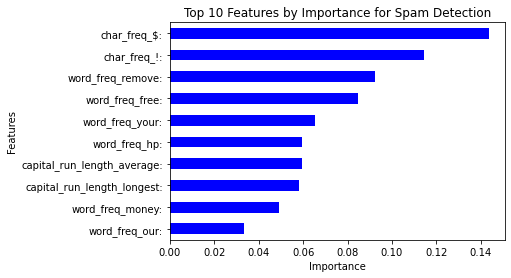

In [29]:
# plot the features and importance 
top_df.plot(kind='barh', color='b', legend=None)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.title('Top 10 Features by Importance for Spam Detection')
plt.show()

From this output we can see that based on the model, the top 5 features in an email that are best at predicting spam are the frequency of characters "$", and "!", and the words "remove", "free" and "your". 